### **AIML Capstone Project - RSNA Pneumonia Detection **
Group 3A:

Contributor - Bathi Babu Doddi, Ashok Shanmuga Sundaram, Ajay Bhagirath, Rajagopalan V, Avaanticka Narayan

Mentor - Sheikh Mohammed Imran

## **RSNA Pneumonia Detection**

Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli.

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as 
positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating 
interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.

Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box.

## **Objective:**
The objective of this project is to build an algorithm to locate the position of inflammation in a medical image. The algorithm needs to  locate lung opacities on chest radiographs automatically

The objective of the project is,
* Learn to how to do build an Object Detection Model
* Use transfer learning to fine-tune a model.
* Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.
* Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.


#### Acknowledgment for the datasets: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements

In [1]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

### **1.0 Importing and installing the necessary Libraries**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Enable the below installation packages if not already installed

In [3]:
# !pip install tensorflow
# !pip install tensorflow-gpu
# !pip install tqdm
# !pip install pydicom
# !pip install -U albumentations

In [4]:
# %tensorflow_version 2.x
%matplotlib inline

In [5]:
import tensorflow as tf

In [6]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
from glob import glob
import os
import time
import math
import fnmatch

from zipfile import ZipFile
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from matplotlib.patches import Rectangle
import pydicom as dicom
import seaborn as sns

from sklearn.utils import shuffle
from skimage.measure import label, regionprops
from sklearn.metrics import precision_recall_fscore_support as prf

import albumentations as A

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import Conv2D, Input, Flatten, Dense, Dropout, Concatenate, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy


### **1.1. EDA and Visualization**

*   Importing Data
*   Analysing the dimensions of data
*   Visualizing the data


In [8]:
# rootDir='drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/'
rootDir='D:/Bathi/work/personal/Learn/Capstone/'
zipFilename=rootDir+'rsna-pneumonia-detection-challenge.zip'
datasetPath=rootDir+'rsna-pneumonia-detection-challenge/'

In [9]:
if os.path.exists(zipFilename):
    if not os.path.exists(datasetPath):
      with ZipFile(zipFilename, 'r') as zip:
        zip.extractall(datasetPath)

The input folder contains 4 important information
* stage_2_train_labels.csv - CSV file containing the patient id, bounding boxes and target label
* stage_2_detailed_class_info.csv - CSV file containing the detail informaiton of patientid and the corresponding label
* stage_2_train_images - directory contains train images in DICOM format
* stage_2_test_images - directory contains test images in DICOM format

In [10]:
trainImagesDir=datasetPath+'stage_2_train_images/'
testImagesDir=datasetPath+'stage_2_test_images/'
sampleSubmission=datasetPath+'stage_2_sample_submission.csv'
classInfo=datasetPath+'stage_2_detailed_class_info.csv'
rsnaLink=datasetPath+'GCP Credits Request Link - RSNA.txt'
trainLabels=datasetPath+'stage_2_train_labels.csv'


In [11]:
os.path.exists(trainImagesDir)

True

Due to high volume of data, sometimes the google drive timeout while reading the files in the directory. Re-execute the code if it fails

In [12]:
# image_train_path = os.listdir(trainImagesDir)
# image_test_path = os.listdir(testImagesDir)
# print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

In [13]:
image_train_path = glob(trainImagesDir+'*.dcm')
image_test_path = glob(testImagesDir+'*.dcm')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


In [14]:
# Loading the data
# There are two input files given - Detailed class info and train labels
class_info_df = pd.read_csv(classInfo)
train_labels_df = pd.read_csv(trainLabels) 

In [15]:
print("Detailed class info -  rows: {}, columns: {}".format(class_info_df.shape[0], class_info_df.shape[1]))
print("Train labels -  rows: {}, columns: {}".format(train_labels_df.shape[0], train_labels_df.shape[1]))

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [16]:
class_info_df.head(10)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

In [17]:
train_labels_df.head(10)

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In Detailed class info dataset , the detailed information about the type of class associated with a certain patientId is given. It has 3 entries "Lung Opacity", "Normal" and "No Lung Opacity/Not Normal"

The CSV file contains PatientId, bounding box details with (x,y) coordinates and width and height that encapsulates the box. It also contains the Target variable. For target variable 0, the bounding box values has NaN values.


If we look closely, there are duplicate entries for patientId in the csv files. We can observe row #4 and #5, row #8 and #9 have same patientId values, aka, the patient is identified with pneumonia at multiple areas in lungs

Check the unique patient ID in the train dataset

In [18]:
print("Unique patientId in  train_class_df: ", train_labels_df['patientId'].nunique())

Unique patientId in  train_class_df:  26684


#### **Checking missing data in two datasets**

In [19]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


For the info of the data, we observe that of the total 30227 rows, 9555 rows has non null. So, all bounding boxes are either defined or not defined.

In [20]:
print(train_labels_df[train_labels_df.Target==0].shape[0])
print(train_labels_df[train_labels_df.Target==1].shape[0])

20672
9555


We see from above that the total number of patientIds that are identified with Pneumonia are 9555 and it matches to the non null values. It can be inferred from this that all pneumonia data set has bounding boxes defined and for normal patients, no bounding boxes exist.

In [21]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_labels_df)

height         width             y             x  Target  \
Total    20672.000000  20672.000000  20672.000000  20672.000000     0.0   
Percent     68.389188     68.389188     68.389188     68.389188     0.0   

         patientId  
Total          0.0  
Percent        0.0

In [22]:
missing_data(class_info_df)

class  patientId
Total      0.0        0.0
Percent    0.0        0.0

68.38% of values are missing for x,y, height and width in train labels for target 0 (not Lung opacity) in train labels dataset

#### **Checking class distribution in Detailed class info dataset**

In [23]:
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)
sns.set_palette('Set2')

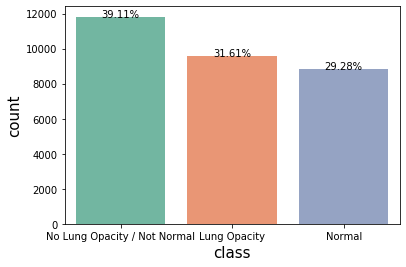

In [24]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(class_info_df.shape[0])
sns.countplot(class_info_df['class'], order = class_info_df['class'].value_counts().index)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [25]:
# More details on classes - No Lung Opacity / Not Normal, Lung Opacity, Normal

def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = data.shape[0]

    # Count the number of items in each class
    print("{:<30s}:   count(percentage)".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = round((count / total_samples) * 100, 2)
        print("{:<30s}:   {}({}%)".format(label, count, percent))

get_feature_distribution(class_info_df, 'class')


class                         :   count(percentage)
No Lung Opacity / Not Normal  :   11821(39.11%)
Lung Opacity                  :   9555(31.61%)
Normal                        :   8851(29.28%)


No Lung Opacity / Not Normal and Normal have together the same percent (68.39%) as the percent of missing values for target window in class details information.

In the train set, the percent of data with pneumonia is therefore 31.61%.

In [26]:
train_labels_df.Target.unique()

array([0, 1], dtype=int64)

The target has two classifications 0 and 1 namely Normal and Pneumonia

#### **Merging train labels and Detailed class info datasets to get more insights**

In [27]:
train_labels_df.shape[0], class_info_df.shape[0]

(30227, 30227)

In [28]:
# merging the two datasets (train and class detail info) using Patient ID as the merge criteria
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [29]:
train_class_df.sample(5)

patientId      x      y  width  height  \
15019  7bab06ba-97af-4635-b729-f3be8dbce660    NaN    NaN    NaN     NaN   
18148  8f88e942-6de5-4c75-96eb-edff7ded7a8d  505.0   13.0  445.0   600.0   
27439  c3b9b37a-812c-439e-913f-39e94b8ec870  194.0  305.0  298.0   401.0   
3076   3011a504-67f0-4bda-b774-46cb7c38b839  685.0  244.0  145.0   352.0   
10488  5c48c1c5-5886-4217-bd5c-90eeb5f92b90    NaN    NaN    NaN     NaN   

       Target                         class  
15019       0                        Normal  
18148       1                  Lung Opacity  
27439       1                  Lung Opacity  
3076        1                  Lung Opacity  
10488       0  No Lung Opacity / Not Normal

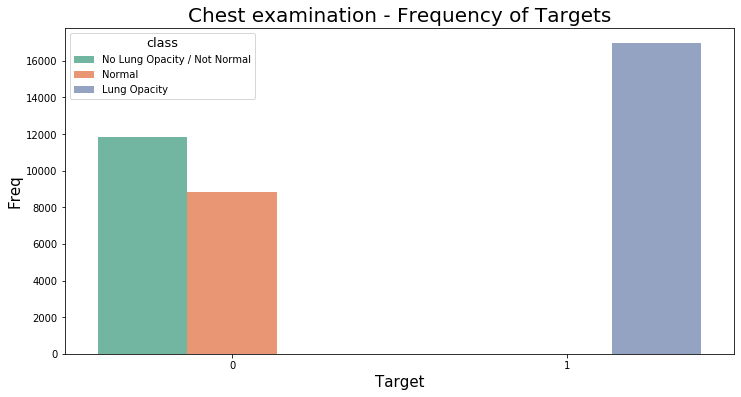

In [30]:
#plotting the number of examinations for each class detected, grouped by Target value
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Freq': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax, x='Target', y='Freq', hue='class', data=df)
plt.title("Chest examination - Frequency of Targets")
plt.show()

Exploring Dicom image files - Reading training & test files

#### **Extracting a single image and processing DICOM information**

In [31]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(trainImagesDir, samplePatientID)
dicom_file_dataset = dicom.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

It is observed that some useful information are available in the DICOM metadata with predictive values, for example:

Patient sex, Patient age, Modality, Body part examined, View position, Rows & Columns, Pixel Spacing

#### **Plotting dicom images with Target = 1**

In [32]:
def show_dicom_images(data, bbox=False):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,2, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(trainImagesDir, patientImage)
        data_row_img_data = dicom.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dicom.dcmread(imagePath)
        ax[i//2, i%2].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//2, i%2].axis('off')
        ax[i//2, i%2].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nBounding box: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        if bbox:
          rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
          box_data = list(rows.T.to_dict().values())
          for j, row in enumerate(box_data):
              ax[i//2, i%2].add_patch(Rectangle(xy=(row['x'], row['y']),
                          width=row['width'],height=row['height'], 
                          color="yellow",alpha = 0.1))   
    plt.tight_layout()
    plt.show()

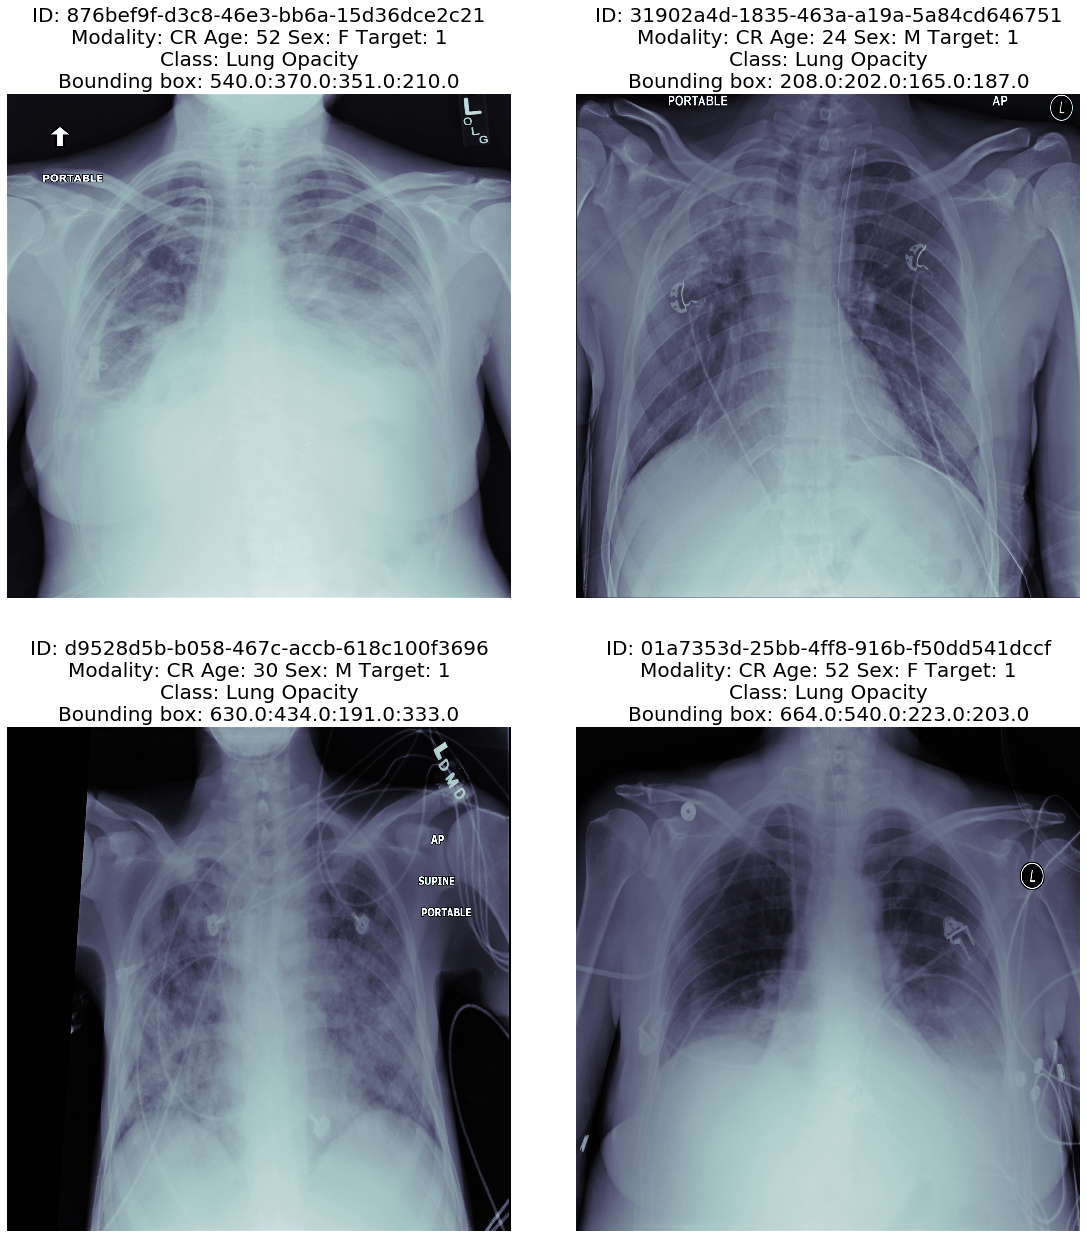

In [33]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(4))

Next step is to represent the images with the overlay boxes superposed. For this, the whole dataset with Target = 1 has to be parsed and all coordinates of the windows showing a Lung Opacity on the same image have to be gathered.

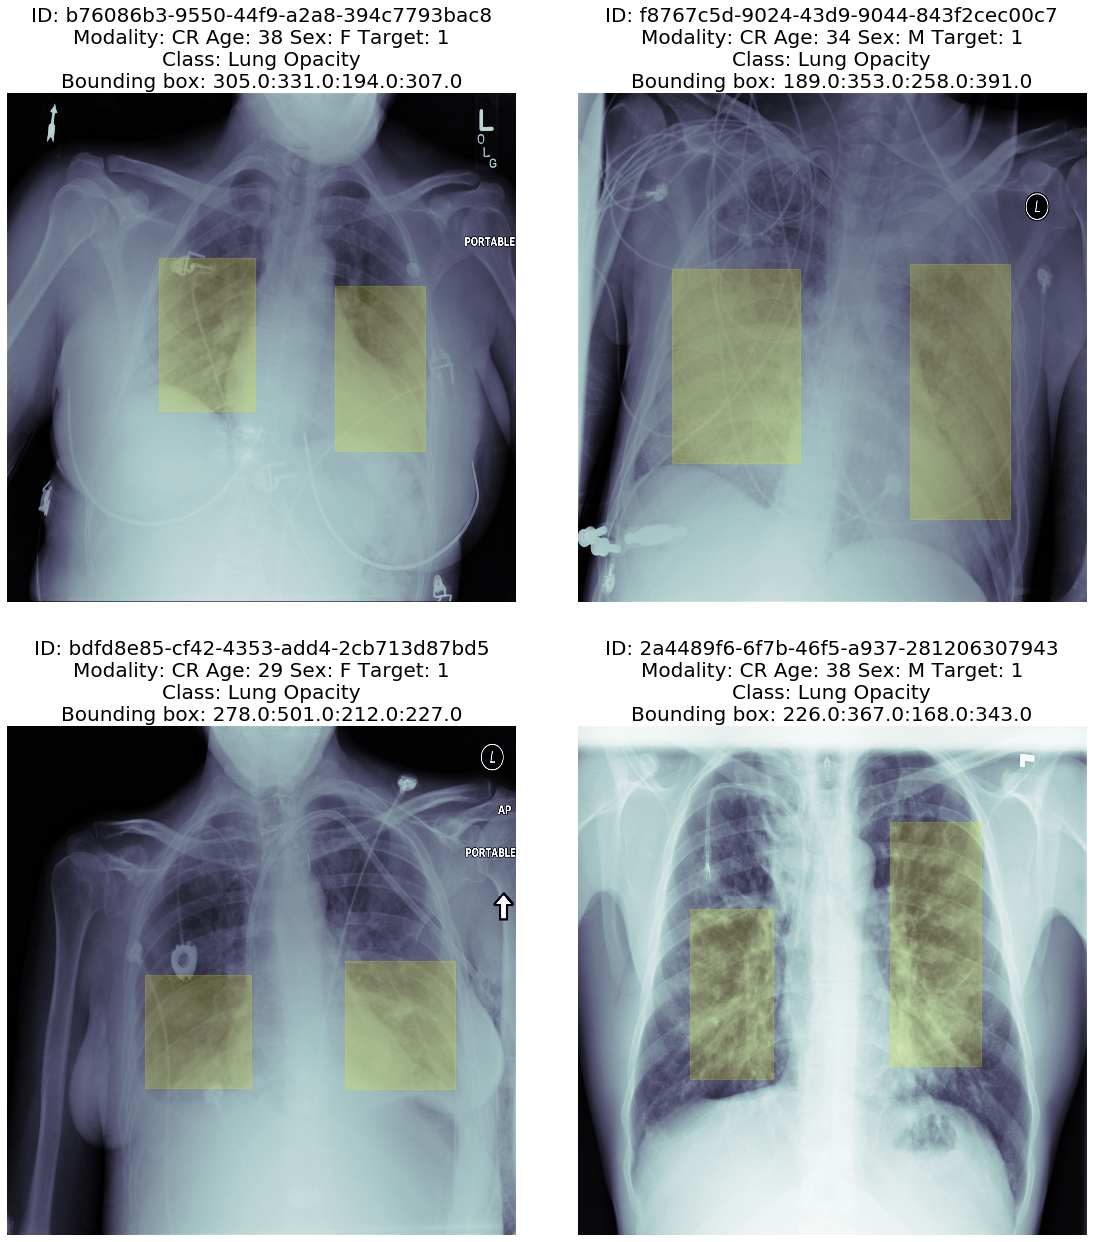

In [34]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(4), bbox=True)

For some of the images with Target=1, we could see multiple areas (boxes/rectangles) with Lung Opacity. 


In [35]:
print('A maximum of {} areas are detected in Lungs for pneumonia patient'.format(max(train_labels_df.patientId.value_counts())))

A maximum of 4 areas are detected in Lungs for pneumonia patient


#### **Plotting DICOM images with Target = 0**

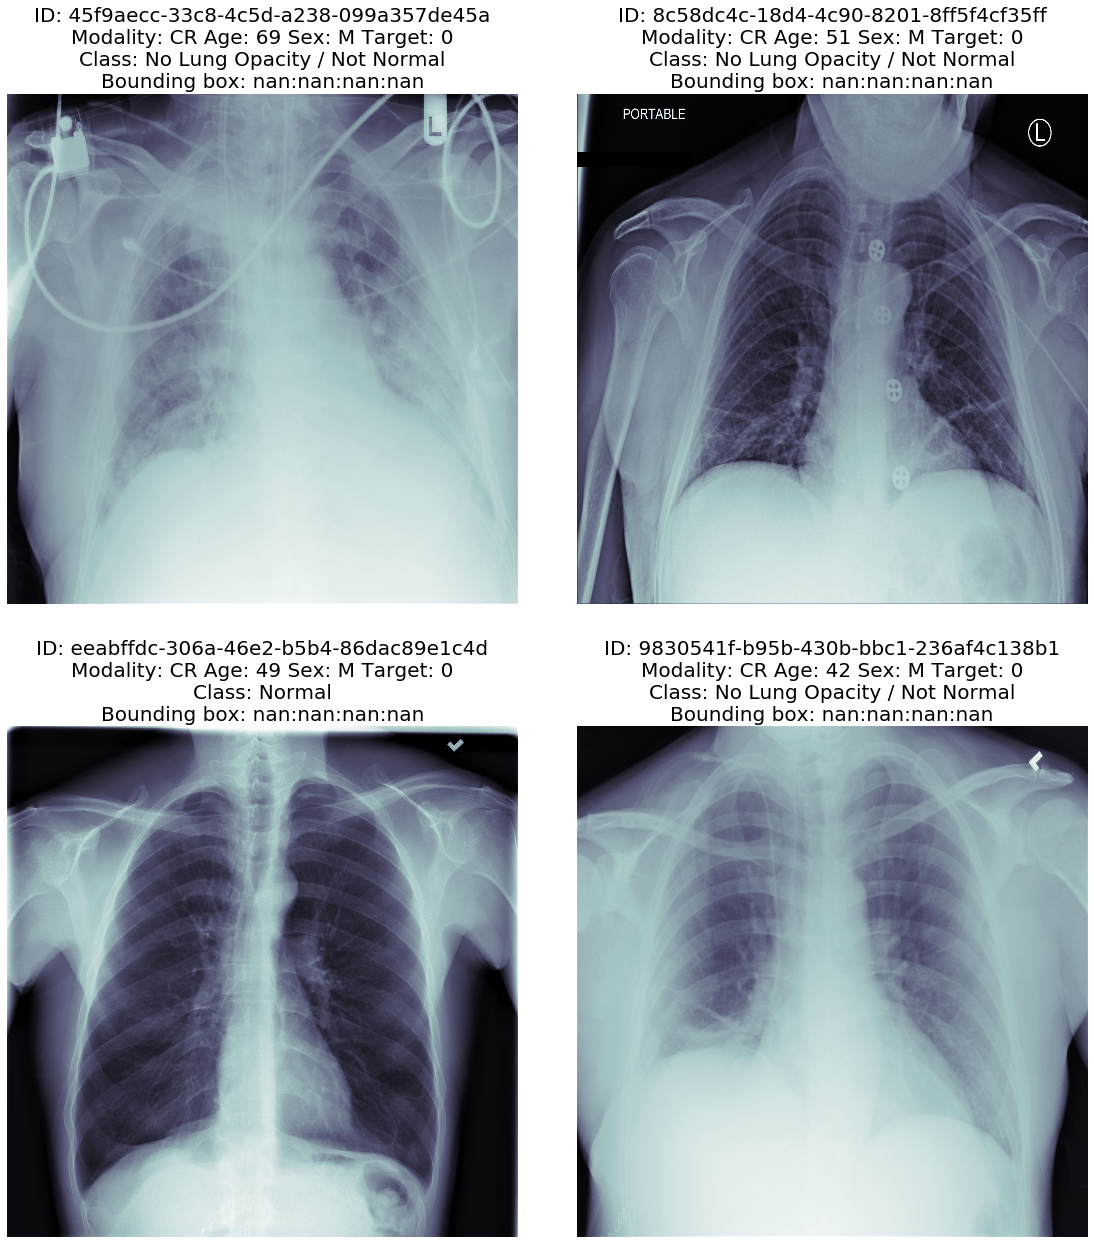

In [36]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(4))

#### **Adding metadata information from Dicom data to train and test datasets**

In [37]:
# parsing the DICOM meta information and add it to the train dataset
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(data_path)
    for i, img_name in tqdm_notebook(enumerate(image_names)):
        imagePath = os.path.join(data_path,img_name)
        data_row_img_data = dicom.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0])
    return data_df

In [38]:
gpuname=tf.test.gpu_device_name()
print('gpu name:',gpuname)
if gpuname:
    with tf.device(gpuname):
        train_class_df = process_dicom_data(train_class_df, trainImagesDir)
else:
        train_class_df = process_dicom_data(train_class_df, trainImagesDir)

gpu name: 


In [39]:
# Creating Test dataset with similar information as that of train set
# stage_2_sample_submission.csv - Contains patientIds for the test set. sample submission contains one box per image, but there is no limit to the number of bounding boxes that can be assigned to a given image.
test_class_df = pd.read_csv(sampleSubmission)
test_class_df.head()

patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100

In [40]:
test_class_df = test_class_df.drop('PredictionString',1)
if gpuname:
    with tf.device(gpuname):
        test_class_df = process_dicom_data(test_class_df, testImagesDir)
else:
    test_class_df = process_dicom_data(test_class_df, testImagesDir)

In [41]:
# Checking how many modalities are used
print("Modalities: train:",train_class_df['Modality'].unique(), "test:", test_class_df['Modality'].unique())

Modalities: train: ['CR'] test: ['CR']


The meaning of this modality is CR - Computer Radiography

In [42]:
# checking if other body parts than 'CHEST' appears in the data
print("Body Part Examined: train:",train_class_df['BodyPartExamined'].unique(), "test:", test_class_df['BodyPartExamined'].unique())

Body Part Examined: train: ['CHEST'] test: ['CHEST']


In [43]:
# View Position is a radiographic view associated with the Patient Position. Let's check the View Positions distribution for the both datasets
print("View Position: train:",train_class_df['ViewPosition'].unique(), "test:", test_class_df['ViewPosition'].unique())

View Position: train: ['PA' 'AP'] test: ['PA' 'AP']


In [44]:
#Train dataset-checking the distribution of PA and AP
get_feature_distribution(train_class_df,'ViewPosition')

ViewPosition                  :   count(percentage)
AP                            :   21817(57.98%)
PA                            :   15812(42.02%)


Both AP and PA body positions are present in the data. The meaning of these view positions are :

AP - Anterior/Posterior; PA - Posterior/Anterior.

Test dataset : Checking the distribution of AP and PA positions for the test set

In [45]:
get_feature_distribution(test_class_df,'ViewPosition')

ViewPosition                  :   count(percentage)
PA                            :   1618(53.93%)
AP                            :   1382(46.07%)


In [46]:
# Conversion Type: Let's check the Conversion Type data
print("Conversion Type: train:",train_class_df['ConversionType'].unique(), "test:", test_class_df['ConversionType'].unique())

Conversion Type: train: ['WSD'] test: ['WSD']


Both train and test have only WSD Conversion Type Data. The meaning of this Conversion Type is WSD: Workstation

In [47]:
# Rows and columns
print("Rows: train:",train_class_df['Rows'].unique(), "test:", test_class_df['Rows'].unique())
print("Columns: train:",train_class_df['Columns'].unique(), "test:", test_class_df['Columns'].unique())

Rows: train: [1024] test: [1024]
Columns: train: [1024] test: [1024]


Only {Rows:Columns} {1024:1024} are present in both train and test.

Even though the size of the images are same, we can observe that each image has different aspect ratio, that is, not all images occupy the same space. Also, the brightness is different.

**Distribution of patient age for the test data set**

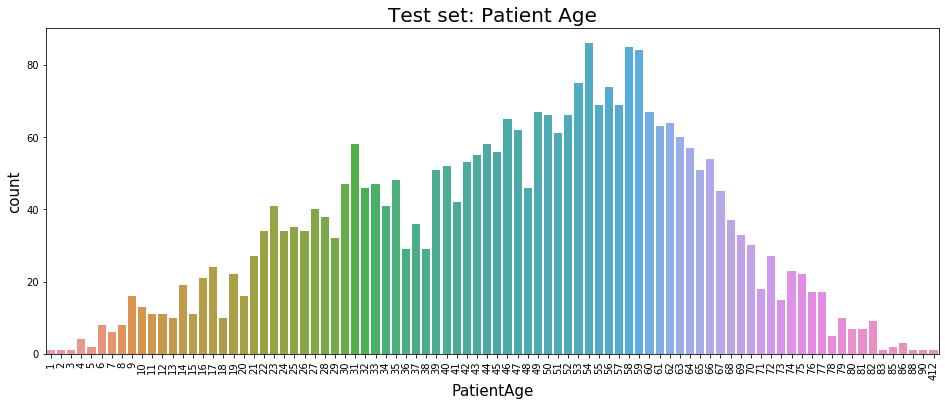

In [48]:
#Test dataset
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.countplot(test_class_df['PatientAge'], ax=ax)
plt.title("Test set: Patient Age")
plt.xticks(rotation=90)
plt.show()

Distribution of Patient Sex for the test data. We can see few age for the dataset is mentioned as 412, which is an incorrect data

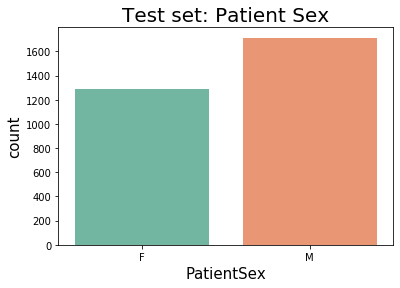

In [49]:
# Test Data
sns.countplot(test_class_df['PatientSex'])
plt.title("Test set: Patient Sex")
plt.show()

**Conclusion**

After exploring both the tabular and DICOM data, we were able to:

1. discover duplications in the tabular data
2. explore the DICOM images
3. extract meta information from the DICOM data
4. add features to the tabular data from the meta information in DICOM data
5. further analyze the distribution of the data with the newly added features from DICOM metadata


All these findings are useful for building a model.

#### **Preprocess the dataset for model input**

In [50]:
def update_dataset(path, df1):
    pid=[]
    label=[]
    bbox=[]

    for name, group in df1.groupby(['patientId','Target']):
        pid.append(path+group['patientId'].tolist()[0]+'.dcm')
        label.append(group['Target'].tolist()[0])
        if group['Target'].tolist()[0] == 1:
            ibbox=[]
            for row in group.iterrows():
                ibbox.append([row[1]['x'], row[1]['y'], row[1]['width'], row[1]['height']])
            bbox.append(ibbox)
        else:
            bbox.append([])
    df = pd.DataFrame({'patientId':pid, 'bboxes': bbox, 'label':label})
    return df

We can observe that the non-null values are 9555 which matches to the patients that have pneumonia problem

In [51]:
df=update_dataset(trainImagesDir, train_labels_df)
print(df.shape)
df.head()

(26684, 3)


patientId  \
0  D:/Bathi/work/personal/Learn/Capstone/rsna-pne...   
1  D:/Bathi/work/personal/Learn/Capstone/rsna-pne...   
2  D:/Bathi/work/personal/Learn/Capstone/rsna-pne...   
3  D:/Bathi/work/personal/Learn/Capstone/rsna-pne...   
4  D:/Bathi/work/personal/Learn/Capstone/rsna-pne...   

                                              bboxes  label  
0                                                 []      0  
1                                                 []      0  
2  [[316.0, 318.0, 170.0, 478.0], [660.0, 375.0, ...      1  
3  [[570.0, 282.0, 269.0, 409.0], [83.0, 227.0, 2...      1  
4  [[66.0, 160.0, 373.0, 608.0], [552.0, 164.0, 3...      1

In [52]:
print('Total number of patients that are normal are {}'.format(df[df.label==0].shape[0]))
print('Total number of patients that have pneumonia are {}'.format(df[df.label==1].shape[0]))

Total number of patients that are normal are 20672
Total number of patients that have pneumonia are 6012


In [53]:
imgWidth=224
imgHeight=224
imgChannels=3
imgSize=(imgHeight, imgWidth)
batchSize=64
labelDict={0:'normal', 1:'lung opacity'}

In [54]:
# def loadImage(row, axis):
#     image_path = row.patientId
#     img = dicom.dcmread(image_path).pixel_array
#     axis.imshow(img, cmap='gray')
#     lbl=labelDict.get(row.label)
#     bboxes=row.bboxes
#     for bbox in bboxes:
#         x=bbox[0]
#         y=bbox[1]
#         w=bbox[2]
#         h=bbox[3]
#         rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='red', fill=False)
#         axis.add_patch(rect)
#     axis.set_title(lbl)
    

In [55]:
# def loadImages(df):
#     cols=5
#     rows=4
#     idx=0
#     f,axarr=plt.subplots(rows,cols,figsize=(18,10))
#     for r in range(rows):
#         for c in range(cols):
#             axis=axarr[r,c]
#             loadImage(df.iloc[idx], axis)
#             idx+=1
#     plt.tight_layout()

In [56]:
# loadImages(df)

Let us print the image with maximum bounding boxes

In [57]:
def check_images_shape(path):
    img_path=glob(path + '*.dcm')
    imagesShape=[dicom.dcmread(image).pixel_array.shape for image in tqdm_notebook(img_path)]
    print(set(imagesShape))
check_images_shape(trainImagesDir)


{(1024, 1024)}


In [58]:
c=math.ceil(df.shape[0]*0.7)
train_df,val_df=df[:c],df[c:]
print(train_df.shape, val_df.shape)

(18679, 3) (8005, 3)


In [59]:
# image transformer object
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])


In [60]:
# Custom datagenerator with mask approach
class CustomDataGen(Sequence):
    
    def __init__(self, df, x_col, y_col, batch_size, input_size=(224, 224, 3), preprocess_function=None, shuffle=True, predict=False, include_labels=False):
        self.df = df.copy(deep=True)
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.predict = predict
        self.n = df.shape[0]
        self.n_class = df[y_col['output1']].nunique()
        self.preprocess_function=preprocess_function
        self.include_labels=include_labels
    
    def on_epoch_end(self):
        if self.shuffle:
            shuffle(self.df.patientId)
    
    def __loadinput(self, img_path, lbl, bboxes):
        image = dicom.dcmread(img_path).pixel_array
        img_size = (image.shape[0],image.shape[1])
        image = cv2.resize(image,(self.input_size[0], self.input_size[1]))
        if len(image.shape) !=3 or image.shape[2]!=3:
            image = np.stack([image] * 3, axis=-1)
        # Add data augmention, for train and validation
        if not self.include_labels:
            image = transform(image=image)['image']
        if self.preprocess_function != None:
            image = self.preprocess_function(image)
        if self.predict:
            return image
        else:
            mask = np.zeros((self.input_size[0], self.input_size[1]))
            for i, bbox in enumerate(bboxes):
                x, y, w, h = bbox
                x1=math.floor(x*self.input_size[1]/img_size[1])
                y1=math.floor(y*self.input_size[0]/img_size[0])
                x2=math.ceil((x+w)*self.input_size[1]/img_size[1])
                y2=math.ceil((y+h)*self.input_size[0]/img_size[0])
                mask[y1:y2, x1:x2] = 1
            if self.include_labels:
                return image, img_path, lbl, mask
            else:
                return image, mask

    
    def __loaddata(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.x_col['input']]
        classes_batch = batches[self.y_col['output1']]
        bboxes_batch = batches[self.y_col['output2']]

        img_batch = [self.__loadinput(filename, lbl, bboxes) for filename, lbl, bboxes in zip(path_batch, classes_batch, bboxes_batch)]
        return img_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        batchdata = self.__loaddata(batches)
        if self.predict:
            return batchdata
        else:
            if self.include_labels:
                image, img_path, lbl, mask = zip(*batchdata)
                return np.array(image), np.array(img_path), np.array(lbl), np.array(mask)
            else:
                image, mask = zip(*batchdata)
                return np.array(image), np.array(mask)

    def __len__(self):
        return math.ceil(self.n / self.batch_size)


Need to identify the distribution (Pneumonia and normal) of the data used
Consider a portion of the dataset for train (2000) and validation (25%) of train size

In [61]:
trainsize=2000
valsize=int(0.25*trainsize)
trainpartial=train_df[:trainsize]
valpartial=val_df[:valsize]
print('Distribution of labels in the train data are ', 
      (trainpartial.label.value_counts().values/trainpartial.label.value_counts().values.sum())*100)
print('Distribution of labels in the validation data are ', 
      (valpartial.label.value_counts().values/valpartial.label.value_counts().values.sum())*100)

Distribution of labels in the train data are  [67.85 32.15]
Distribution of labels in the validation data are  [56.6 43.4]


The distribution of the data in both train and validation is good. Also, the distribution of same label data across the train adn test are also good to proceed

In [62]:
xcol={'input':'patientId'}
ycol={'output1': 'label', 'output2': 'bboxes'}
traingen = CustomDataGen( trainpartial,
                          x_col=xcol,
                          y_col=ycol,
                          batch_size=batchSize, input_size=(imgSize),
                          preprocess_function=preprocess_input
                        )

valgen = CustomDataGen(   valpartial,
                          x_col=xcol,
                          y_col=ycol,
                          batch_size=batchSize, input_size=(imgSize),
                          preprocess_function=preprocess_input
                        )


Freeze initial layers and train the top 3 layers to capture the features for the images that require to train

In [63]:
def create_vgg16_unetmodel(freeze_layers=16):
    print('Creating VGG16 model')
    model = VGG16(input_shape=(imgHeight, imgWidth, 3), include_top=False, weights="imagenet")
    layers = model.layers
    for i in range(freeze_layers):
        layers[i].trainable = False

    #encoder - get output layers for concatenate with the upsampling layer
    block1 = model.get_layer("block1_conv2").output
    block2 = model.get_layer("block2_conv2").output
    block3 = model.get_layer("block3_conv3").output
    block4 = model.get_layer("block4_conv3").output
    block5 = model.get_layer("block5_conv3").output
    # block6 = model.get_layer("block5_pool").output

    #Decoder block
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (block5)
    x = Concatenate()([x, block4])
    x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
    x= BatchNormalization()(x)
    x=Dropout(0.5)(x)

    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (x)
    x = Concatenate()([x, block3])
    x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
    x= BatchNormalization()(x)
    x=Dropout(0.5)(x)

    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x)
    x = Concatenate()([x, block2])
    x = Conv2D(128, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same') (x)
    x= BatchNormalization()(x)
    x=Dropout(0.5)(x)

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)
    x = Concatenate()([x, block1])
    x = Conv2D(64, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same') (x)
    x= BatchNormalization()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    vgg16unetmodel = Model(inputs=model.input, outputs=x)
    
    return vgg16unetmodel


In [64]:
model=create_vgg16_unetmodel()
model.summary()

Creating VGG16 model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_________________________________________________________________________

In [65]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(float(y_true) * float(y_pred))
    score = (intersection + 1.) / (tf.reduce_sum(float(y_true)) + tf.reduce_sum(float(y_pred)) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(float(y_true) * float(y_pred), axis=[1])
    union = tf.reduce_sum(float(y_true),axis=[1]) + tf.reduce_sum(float(y_pred),axis=[1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


In [66]:
model_path=rootDir+"model_unet_vgg16.h5"
checkpoint = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True)
stop = EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6, verbose=1)
adam=Adam(learning_rate=0.01, beta_1=0.9,beta_2=0.99)


In [67]:
start=time.time()
try:
    model.compile(loss=iou_bce_loss, optimizer=adam, metrics=[mean_iou])
    history = model.fit(  traingen,
                          validation_data = valgen,
                          epochs=10,
                          batch_size=batchSize,
                          callbacks=[stop, reduce_lr, checkpoint]
                    )
except Exception as e:
    print(e)
print('Time taken:',time.time()-start)

Epoch 1/10
32/32 [==============================] - 920s 29s/step - loss: 0.6705 - mean_iou: 0.7080 - val_loss: 0.6595 - val_mean_iou: 0.8119

Epoch 00001: val_loss improved from inf to 0.65948, saving model to D:/Bathi/work/personal/Learn/Capstone\model_unet_vgg16.h5
Epoch 2/10
32/32 [==============================] - 920s 29s/step - loss: 0.5621 - mean_iou: 0.8576 - val_loss: 1.0006 - val_mean_iou: 0.8313

Epoch 00002: val_loss did not improve from 0.65948
Epoch 3/10
32/32 [==============================] - 920s 29s/step - loss: 0.5211 - mean_iou: 0.7976 - val_loss: 0.7542 - val_mean_iou: 0.7639

Epoch 00003: val_loss did not improve from 0.65948
Epoch 4/10
32/32 [==============================] - 920s 29s/step - loss: 0.4963 - mean_iou: 0.8161 - val_loss: 1.8864 - val_mean_iou: 0.2521

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00004: val_loss did not improve from 0.65948
Epoch 5/10
32/32 [==============================] - 923s 29s/step - 

loss: 0.4861 - mean_iou: 0.7993 - val_loss: 0.4998 - val_mean_iou: 0.7978


In [68]:
trainpred=model.evaluate(traingen)

32/32 [==============================] - 252s 8s/step - loss: 0.5009 - mean_iou: 0.8765


In [69]:
valpred=model.evaluate(valgen)

8/8 [==============================] - 64s 8s/step - loss: 0.5380 - mean_iou: 0.8277


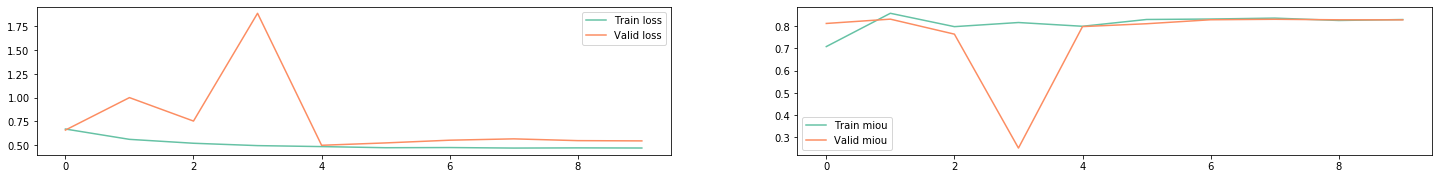

In [70]:
plt.figure(figsize=(25,6))
plt.subplot(221)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(222)
plt.plot(history.epoch, history.history["mean_iou"], label="Train miou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid miou")
plt.legend()
plt.show()

## **Model Evaluation with transfer learning**

In [71]:
def load_saved_model(modelname):
    if os.path.exists(modelname):
        return load_model(model_path, compile=False)
    else:
        print('model does not exist at {}'.format(modelname))

In [72]:
model=load_saved_model(model_path)

In [73]:
def extract_bboxes(mask):
    lbl_0 = label(mask)
    bboxes = regionprops(lbl_0)
    img_boxes=[]
    for bbox in bboxes:
        y1, x1, y2, x2 = bbox.bbox
        w, h = x2-x1, y2-y1
        if w > mask.shape[1]*0.2 and h > mask.shape[0]*0.2: # keep bounding boxes that are atleast 20% of the image size elimiating small areas detected
            img_boxes.append([x1,y1,w,h])
    
    return img_boxes

def calculate_bbox(bboxes, overlapThresh):
    bboxes=np.array(bboxes)
    pick = []
    x1 = bboxes[:,0]
    y1 = bboxes[:,1]
    w = bboxes[:,2]
    h = bboxes[:,3]
    w[w<0]=0
    h[h<0]=0
    x2 = x1 + w
    y2 = y1 + h

    area = (w + 1.0) * (h + 1.0)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > 0.8)[0])))

    return list(bboxes[pick].astype("int"))

def non_maxima_suppression(predmasks, maskTh=0.5, overlapThresh=0.5):
    predABBoxes, predBBoxes=[], []

    for i in range(len(predmasks)):
        bboxes=extract_bboxes(predmasks[i][:,:] > maskTh)
        if len(bboxes) == 0:
            predABBoxes.append([])
        else:
            predABBoxes.append(calculate_bbox(bboxes, overlapThresh))

    for i in range(len(predABBoxes)):
        if len(predABBoxes[i])==0:
            predBBoxes.append(predABBoxes[i])
        else:
            predBBoxes.append([list(y) for y in predABBoxes[i]])

    return predBBoxes


In [74]:
predgen = CustomDataGen(  valpartial,
                          x_col=xcol,
                          y_col=ycol,
                          batch_size=batchSize, input_size=(imgSize),
                          preprocess_function=preprocess_input,
                          include_labels=True
                        )


In [75]:
pred=[]
true=[]
imgs_path=[]
imgs=[]
labels=[]
for images, images_path, lbls, truemasks in tqdm_notebook(predgen):
    imgs_path.extend(images_path)
    imgs.extend(images)
    labels.extend(lbls)
    true.extend(truemasks)
    pred_mask=model.predict(x=[images])
    pred.extend(pred_mask)
pred=tf.image.resize(pred, (1024, 1024))
pred=non_maxima_suppression(np.asarray(pred).squeeze())


In [76]:
predDF=pd.DataFrame({'patientId':imgs_path, 'predbboxes':pred})
predDF['predlbls']=predDF['predbboxes'].apply(lambda x:1 if len(x)>0 else 0)
predDF.sort_values(by='patientId', ignore_index=True, inplace=True)
combinedDF=pd.merge(valpartial, predDF)

In [92]:
def loadImage(idx, df, axis):
    img_file=df.iloc[idx]['patientId']

    image = dicom.dcmread(img_file).pixel_array
    axis.imshow(image, cmap=plt.cm.bone)

    bboxes = df.iloc[idx]['bboxes']
    for bbox in bboxes:
        x,y,w,h=bbox
        rect1 = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='red', fill=False)
        axis.add_patch(rect1)

    bboxes=df.iloc[idx]['predbboxes']
    for bbox in bboxes:
        x,y,w,h=bbox
        rect2 = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='green', fill=False)
        axis.add_patch(rect2)
    axis.set_title('Actual:Predicted\n' + labelDict.get(df.iloc[idx]['label']) + 
                   ':' +labelDict.get(1 if len(df.iloc[idx]['predbboxes'])>0 else 0))
    
    
def display_actual_preds(df):
    cols=3
    rows=4
    f,axarr=plt.subplots(rows,cols,figsize=(18,10))
    for r in range(rows):
        for c in range(cols):
            axis=axarr[r,c]
            loadImage(np.random.randint(valpartial.shape[0]), df, axis)
    plt.tight_layout()

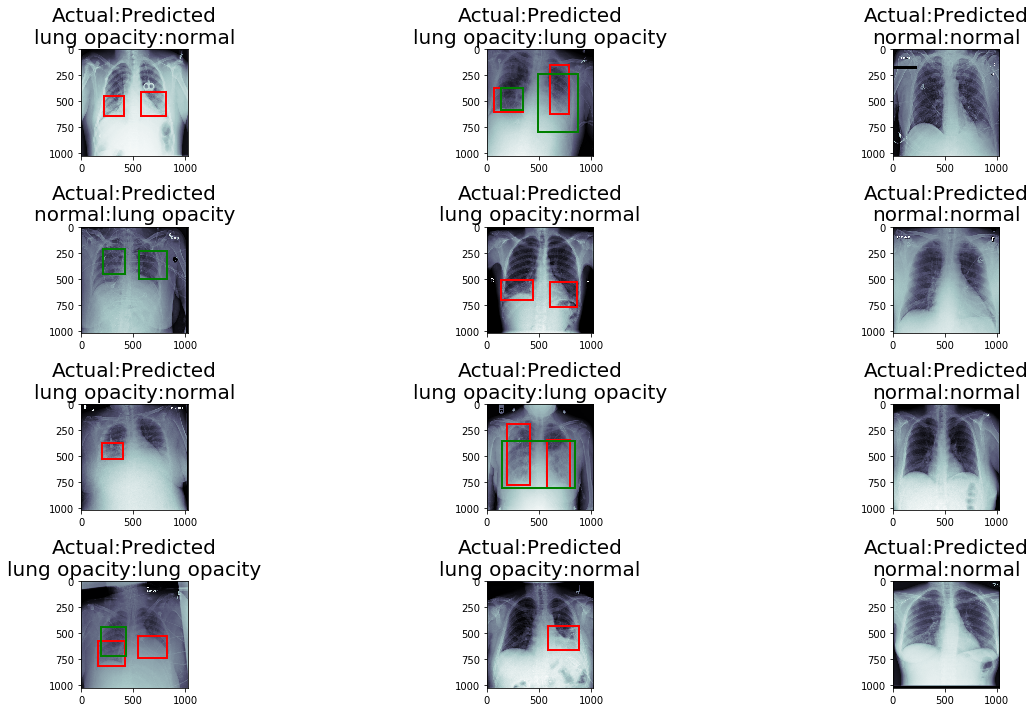

In [93]:
display_actual_preds(combinedDF)

Calculate Precision, recall and F1score for classification and IOU for bounding box predictions


In [94]:
prec, rec, f1s, _ = prf(combinedDF['label'], combinedDF['predlbls'], average='binary')

In [95]:
print('The precision, recall and f1-score for the classification ofpneumonia data set is \
       {}, {} and {} respectively'.format(round(prec,3), round(rec, 3), round(f1s, 3)))

The precision, recall and f1-score for the classification ofpneumonia data set is        0.84, 0.654 and 0.736 respectively
